In [300]:
import numpy as np
import pandas as pd

from scipy.stats import norm, skew, kurtosis

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PowerTransformer

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# 1) Loading Data

In [301]:
df = pd.read_csv("data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [302]:
df.drop(['Id'], axis=1, inplace=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [303]:
df1 = df.copy()

# 2) Missing Values

In [304]:
def missing_vals(df):
    
    missing = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).values
    
    percentage = (df.isna().mean()*100)[df.isna().mean()*100 > 0].sort_values(ascending=False).values
    
    names = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).index
    
    dtypes = df[names].dtypes.values
    
    data = np.array([dtypes, missing, percentage]).T
    
    return pd.DataFrame(data=data, index=names, columns=['Dtypes', '#Missing Values', '%Missing Values'])

In [305]:
missing_vals(df1)

,Dtypes,#Missing Values,%Missing Values
PoolQC,object,1453,99.520548
MiscFeature,object,1406,96.30137
Alley,object,1369,93.767123
Fence,object,1179,80.753425
FireplaceQu,object,690,47.260274
LotFrontage,float64,259,17.739726
GarageType,object,81,5.547945
GarageYrBlt,float64,81,5.547945
GarageFinish,object,81,5.547945
GarageQual,object,81,5.547945


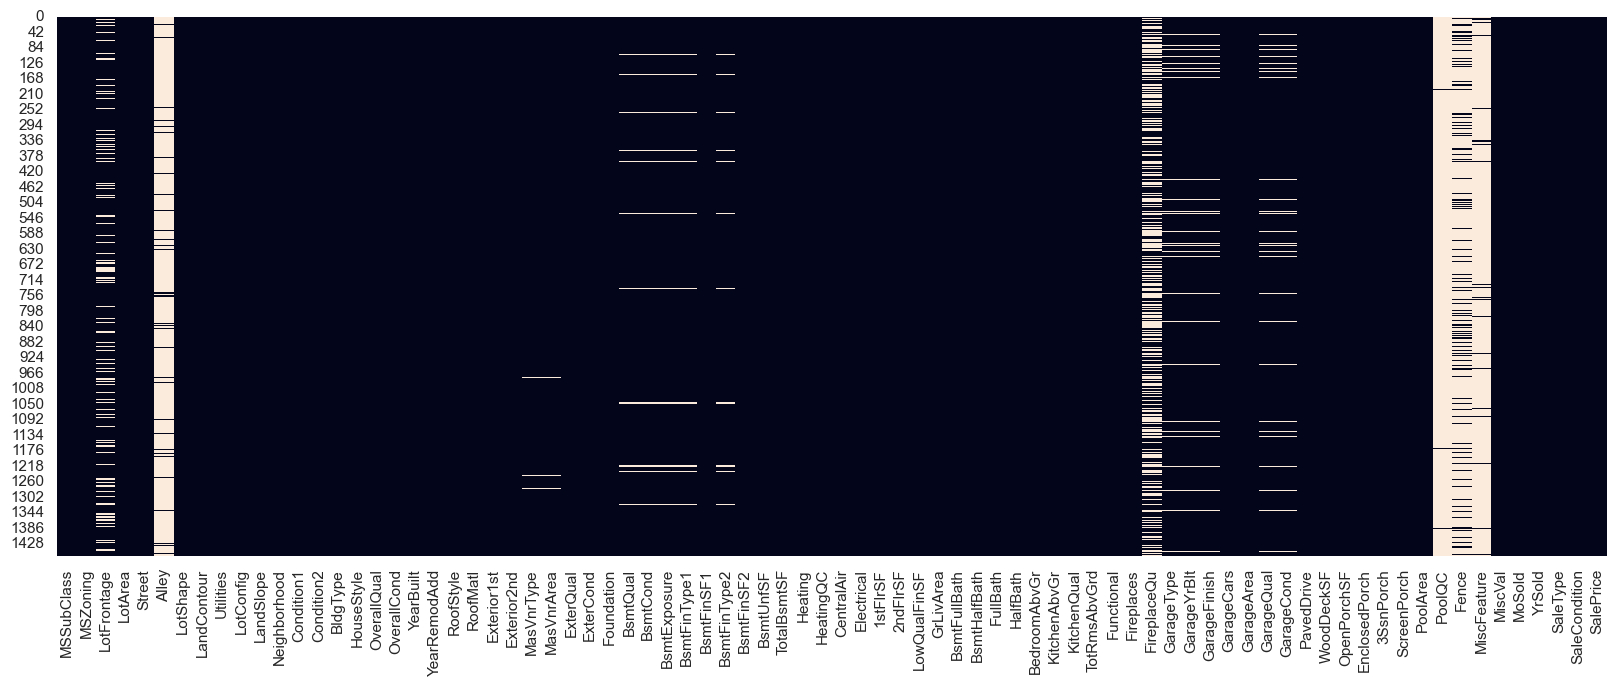

In [306]:
plt.figure(figsize=(20, 7))
sns.heatmap(df1.isna(), cbar=False)
plt.show()

In [307]:
fill_zero = ['MasVnrArea', 'GarageArea', 'GarageYrBlt']
df1[fill_zero] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(df1[fill_zero])

change_cat = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold', 'OverallQual', 'OverallCond']
df1[change_cat] = df1[change_cat].astype(object)

fill_none = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType']
df1[fill_none] = SimpleImputer(strategy='constant', fill_value='None').fit_transform(df1[fill_none])

delete_rows = ['Electrical']
df1.dropna(axis=0, subset=delete_rows, inplace=True)

fill_num = ['LotFrontage']
df1[fill_num] = KNNImputer(n_neighbors=5).fit_transform(df1[fill_num])

In [308]:
missing_vals(df1)

,Dtypes,#Missing Values,%Missing Values


In [309]:
df2 = df1.copy()

# 3) Feature Engineering

In [310]:
# Square per Room
df2["SqFtPerRoom"] = df2["GrLivArea"] / (df2["TotRmsAbvGrd"] + df2["FullBath"] + df2["HalfBath"] + df2["KitchenAbvGr"])

# Total Home Quality
df2['Total_Home_Quality'] = df2['OverallQual'] + df2['OverallCond']

# Total Bathrooms
df2['Total_Bathrooms'] = (df2['FullBath'] + (0.5*df2['HalfBath']) + df2['BsmtFullBath'] + (0.5*df2['BsmtHalfBath']))

# HighQualSF
df2["HighQualSF"] = df2["1stFlrSF"] + df2["2ndFlrSF"]

In [311]:
df3 = df2.copy()

# 4) Target Transformation

In [312]:
def skew_kurtosis(df):
    
    numeric_features = df.dtypes[df.dtypes != 'object'].index
    
    skewness_vals = df[numeric_features].apply(axis=0, func=lambda x: skew(x)).values
    
    kurtosis_vals = df[numeric_features].apply(axis=0, func=lambda x: kurtosis(x)).values
    
    data = np.array([skewness_vals, kurtosis_vals]).T
    
    return pd.DataFrame(data=data, index=numeric_features, columns=['Skewness', 'Kurtosis'])

In [313]:
skew_kurtosis(df3[['SalePrice']])

,Skewness,Kurtosis
SalePrice,1.880008,6.502799


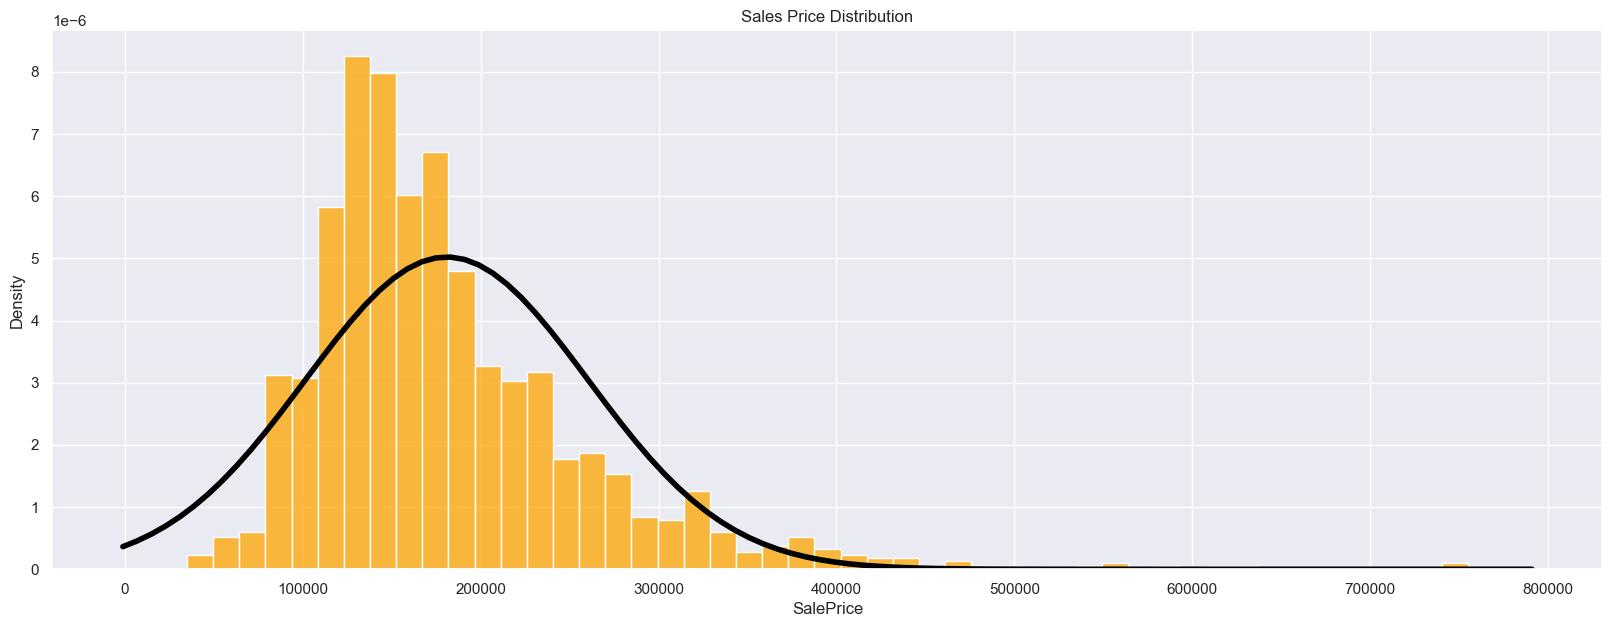

In [314]:
plt.figure(figsize=(20, 7))
ax = sns.histplot(df3['SalePrice'], stat='density', color='orange')
mu, std = norm.fit(df3['SalePrice'])
xx = np.linspace(*ax.get_xlim(),100)
plt.title('Sales Price Distribution')
ax.plot(xx, norm.pdf(xx, mu, std), c='black', lw=4)
plt.show()

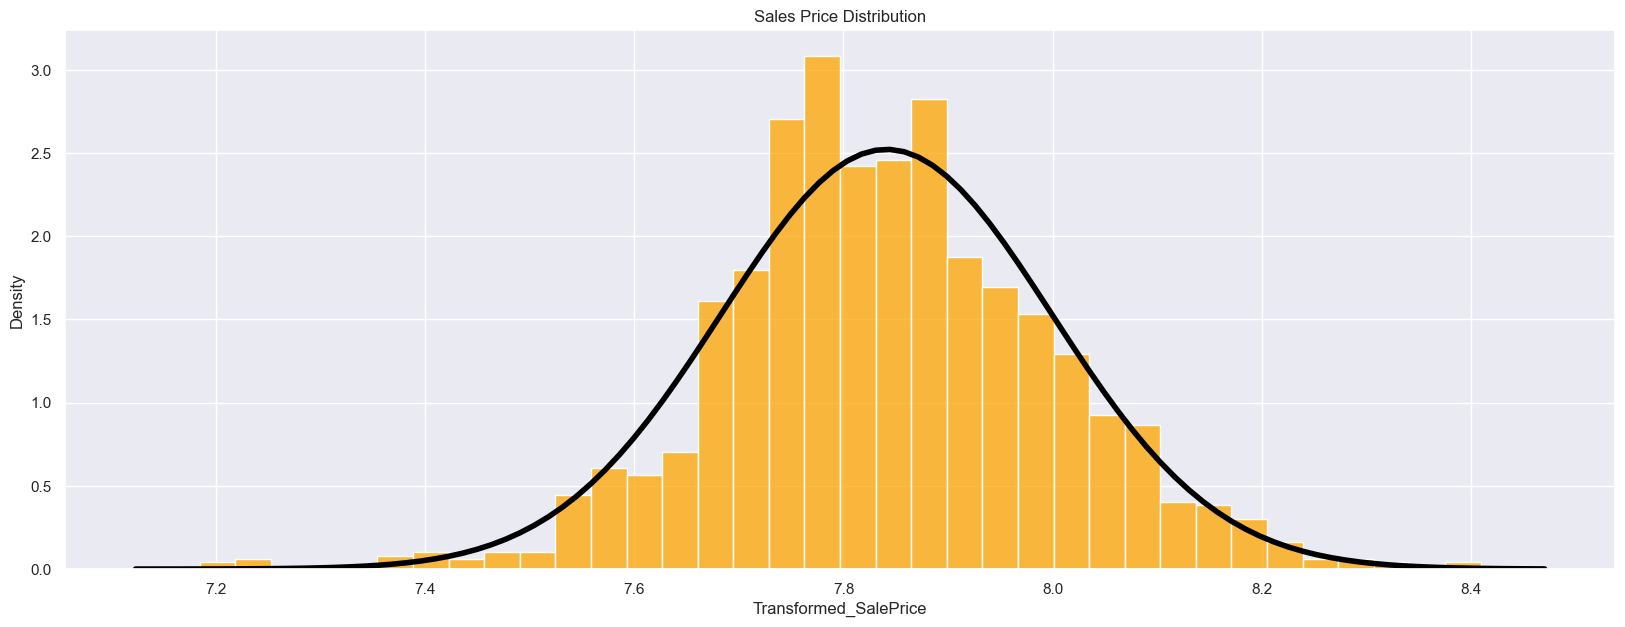

In [315]:
target_transformer = PowerTransformer(method='yeo-johnson', standardize=False)

df3['Transformed_SalePrice'] = target_transformer.fit_transform(df3[['SalePrice']]).T[0]

plt.figure(figsize=(20, 7))
ax2 = sns.histplot(df3['Transformed_SalePrice'], stat='density', color='orange')
mu2, std2 = norm.fit(df3['Transformed_SalePrice'])
xx2 = np.linspace(*ax2.get_xlim(),100)
plt.title('Sales Price Distribution')
ax2.plot(xx2, norm.pdf(xx2, mu2, std2), c='black', lw=4)
plt.show()

In [316]:
df3.drop(['SalePrice'], axis=1, inplace=True)
df4 = df3.copy()

# 5) Features Transformation

In [317]:
skew_kurtosis(df4.drop(['Transformed_SalePrice'], axis=1))

,Skewness,Kurtosis
LotFrontage,2.382060,21.754015
LotArea,12.190881,202.402120
MasVnrArea,2.673798,10.095230
BsmtFinSF1,1.683465,11.079615
BsmtFinSF2,4.249219,20.023898
BsmtUnfSF,0.918367,0.466639
TotalBsmtSF,1.525190,13.232154
1stFlrSF,1.375089,5.724629
2ndFlrSF,0.813466,-0.554484
LowQualFinSF,8.998885,82.885802


In [318]:
skewed_values = skew_kurtosis(df4.drop(['Transformed_SalePrice'], axis=1))

threshold = (np.abs(skewed_values['Skewness']) < 2) | (np.abs(skewed_values['Kurtosis']) < 7)

skewed_values[threshold]

,Skewness,Kurtosis
BsmtFinSF1,1.683465,11.079615
BsmtUnfSF,0.918367,0.466639
TotalBsmtSF,1.525190,13.232154
1stFlrSF,1.375089,5.724629
2ndFlrSF,0.813466,-0.554484
GrLivArea,1.364297,4.868582
BsmtFullBath,0.594354,-0.841470
FullBath,0.037821,-0.858040
HalfBath,0.677275,-1.073973
BedroomAbvGr,0.211839,2.215847


In [319]:
skewed_features = skewed_values[threshold].index
skewed_features

parameter_transformer = PowerTransformer(method='yeo-johnson', standardize=False)

df4[skewed_features] = parameter_transformer.fit_transform(df4[skewed_features])

In [320]:
df5 = df4.copy()

# 8) Encoding

# 9) Scaling

# 6) Feature Selection

# 7) Outlier Removal

# 10) Splitting Data

# 11) Model Selection

# 12) HyperParameter Optimization

# 13) Model Training

# 14) Results